In [1]:
%load_ext autoreload

In [2]:
import sys
sys.path.insert(0, '..')

In [3]:
from toi5671 import read_all_phot, colors, np, pl

/opt/miniconda3/envs/toi5671/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
lcs = read_all_phot(phot_dir='../data/photometry')
del lcs['TESS'] 
lcs.keys()

/Users/jpdl/github/research/project/toi5671/notebooks/../toi5671.py:1815: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(fp, delim_whitespace=True)
/Users/jpdl/github/research/project/toi5671/notebooks/../toi5671.py:1766: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(fp, delim_whitespace=True)
/Users/jpdl/github/research/project/toi5671/notebooks/../toi5671.py:1847: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(fp, delim_whitespace=True)


FileNotFoundError: [Errno 2] No such file or directory: '../data/photometry/TIC_119585136-01_20230124_SPECULOOS-North-1.0m_gp_Artemis_measurments.txt'

In [ ]:
pwd

In [ ]:
nbands = len(lcs)
nbands

In [ ]:
nlcs = sum([len(v) for k,v in lcs.items()])
nlcs

In [ ]:
period = 3.3079817 #± 0.0006559
t0 = 2459685.753346 #± 0.0018235 

In [ ]:
def get_epoch_tc(times, period, t0):
    n = int(np.floor((max(times)-t0)/period))
    return t0+n*period

t = lcs['V']['lco1m'].BJD_TDB.values
tc = get_epoch_tc(t, period, t0)
t-tc

In [ ]:
fig = pl.figure(figsize=(8,16))
i = 0
for band,dfs in lcs.items():
    for inst,df in dfs.items():
        ax = fig.add_subplot(nlcs//3+1,3,1+i)

        t = df.BJD_TDB
        f = df.Flux/np.median(df.Flux)
        tc = get_epoch_tc(t, period, t0)
        ax.plot(t-tc, f, color=colors[band])
        ax.set_title(f'{inst}/{band}')
        i+=1
        ax.set_ylim(0.9, 1.05)
# fig.tight_layout()

In [ ]:
from toi5671 import Star, Planet

target_name = 'TOI-5671'
star = Star(target_name)
star_params = star.params_to_dict()
star_params

In [ ]:
planet = Planet(target_name, star_params=star_params, alias='.01', source='toi')
planet_params = planet.params_to_dict()
planet_params

In [ ]:
#from joint M3 fit
planet_params['t0'] = (2459401.2798851826, 0.0003721565008163452) #from all_lc fit
planet_params['period'] =  (3.30782176247877, 2.8107177292291396e-06) #from all_lc fit
planet_params['tdur'] = (1.8007676079333526/24,	0.00952930506810823/24)
planet_params['rprs'] = (0.27458414702194084, 0.001118462750906879)
# planet_params['period'] =  (3.30783,0.0001) #from trial and error
# planet_params['tdur'] = (0.0752, 0.0003)

In [ ]:
from toi5671 import TransitFit

lcs = read_all_phot(phot_dir='../data/photometry')
del lcs['TESS']
lcs.keys()

In [ ]:
tf = TransitFit(name=target_name, 
                alias='b',
                star_params=star_params,
                planet_params=planet_params,
                data=lcs,
                model='chromatic',
                use_r1r2=False,
                DEBUG=False
               )
tf.model_params

In [ ]:
tf.bands

In [ ]:
tf.instruments

In [ ]:
fig = tf.plot_raw_data()

In [ ]:
tf.optimize_chi2_linear_baseline()

In [ ]:
qc,qe = tf.ldtk_profiles.coeffs_qd()
for i,j in zip(qc,qe):
    print(f"q1={i[0]}")
    print(f"q2={i[1]}")

In [ ]:
pv = tf.pv_updated
tf.get_chi2_transit(pv)

In [ ]:
pv = tf.pv_init
while True:
    tf.optimize_chi2_transit(pv)
    if tf.opt_result.success:
        break

In [ ]:
# using optimized parameters
pv = tf.optimum_params
# pv = [v[0] for k,v in tf.model_params.items()]
fig = tf.plot_lightcurves(pv, figsize=(10,5))

In [ ]:
pv = tf.pv_init
# tf.optimum_params = pv
tf.sample_mcmc(pv, nsteps=1000)

In [ ]:
fig = tf.plot_chain()

In [ ]:
df = tf.get_mcmc_samples(discard=500)
df.head()

In [ ]:
outdir = './joint'
if False:
    outfile = f'{outdir}/{tf.model}_samples.csv.gz'
    df.to_csv(outfile, index=False)
    print("Saved: ", outfile)

In [ ]:
fig = tf.plot_corner(start=0, end=4, discard=500, transform=False)

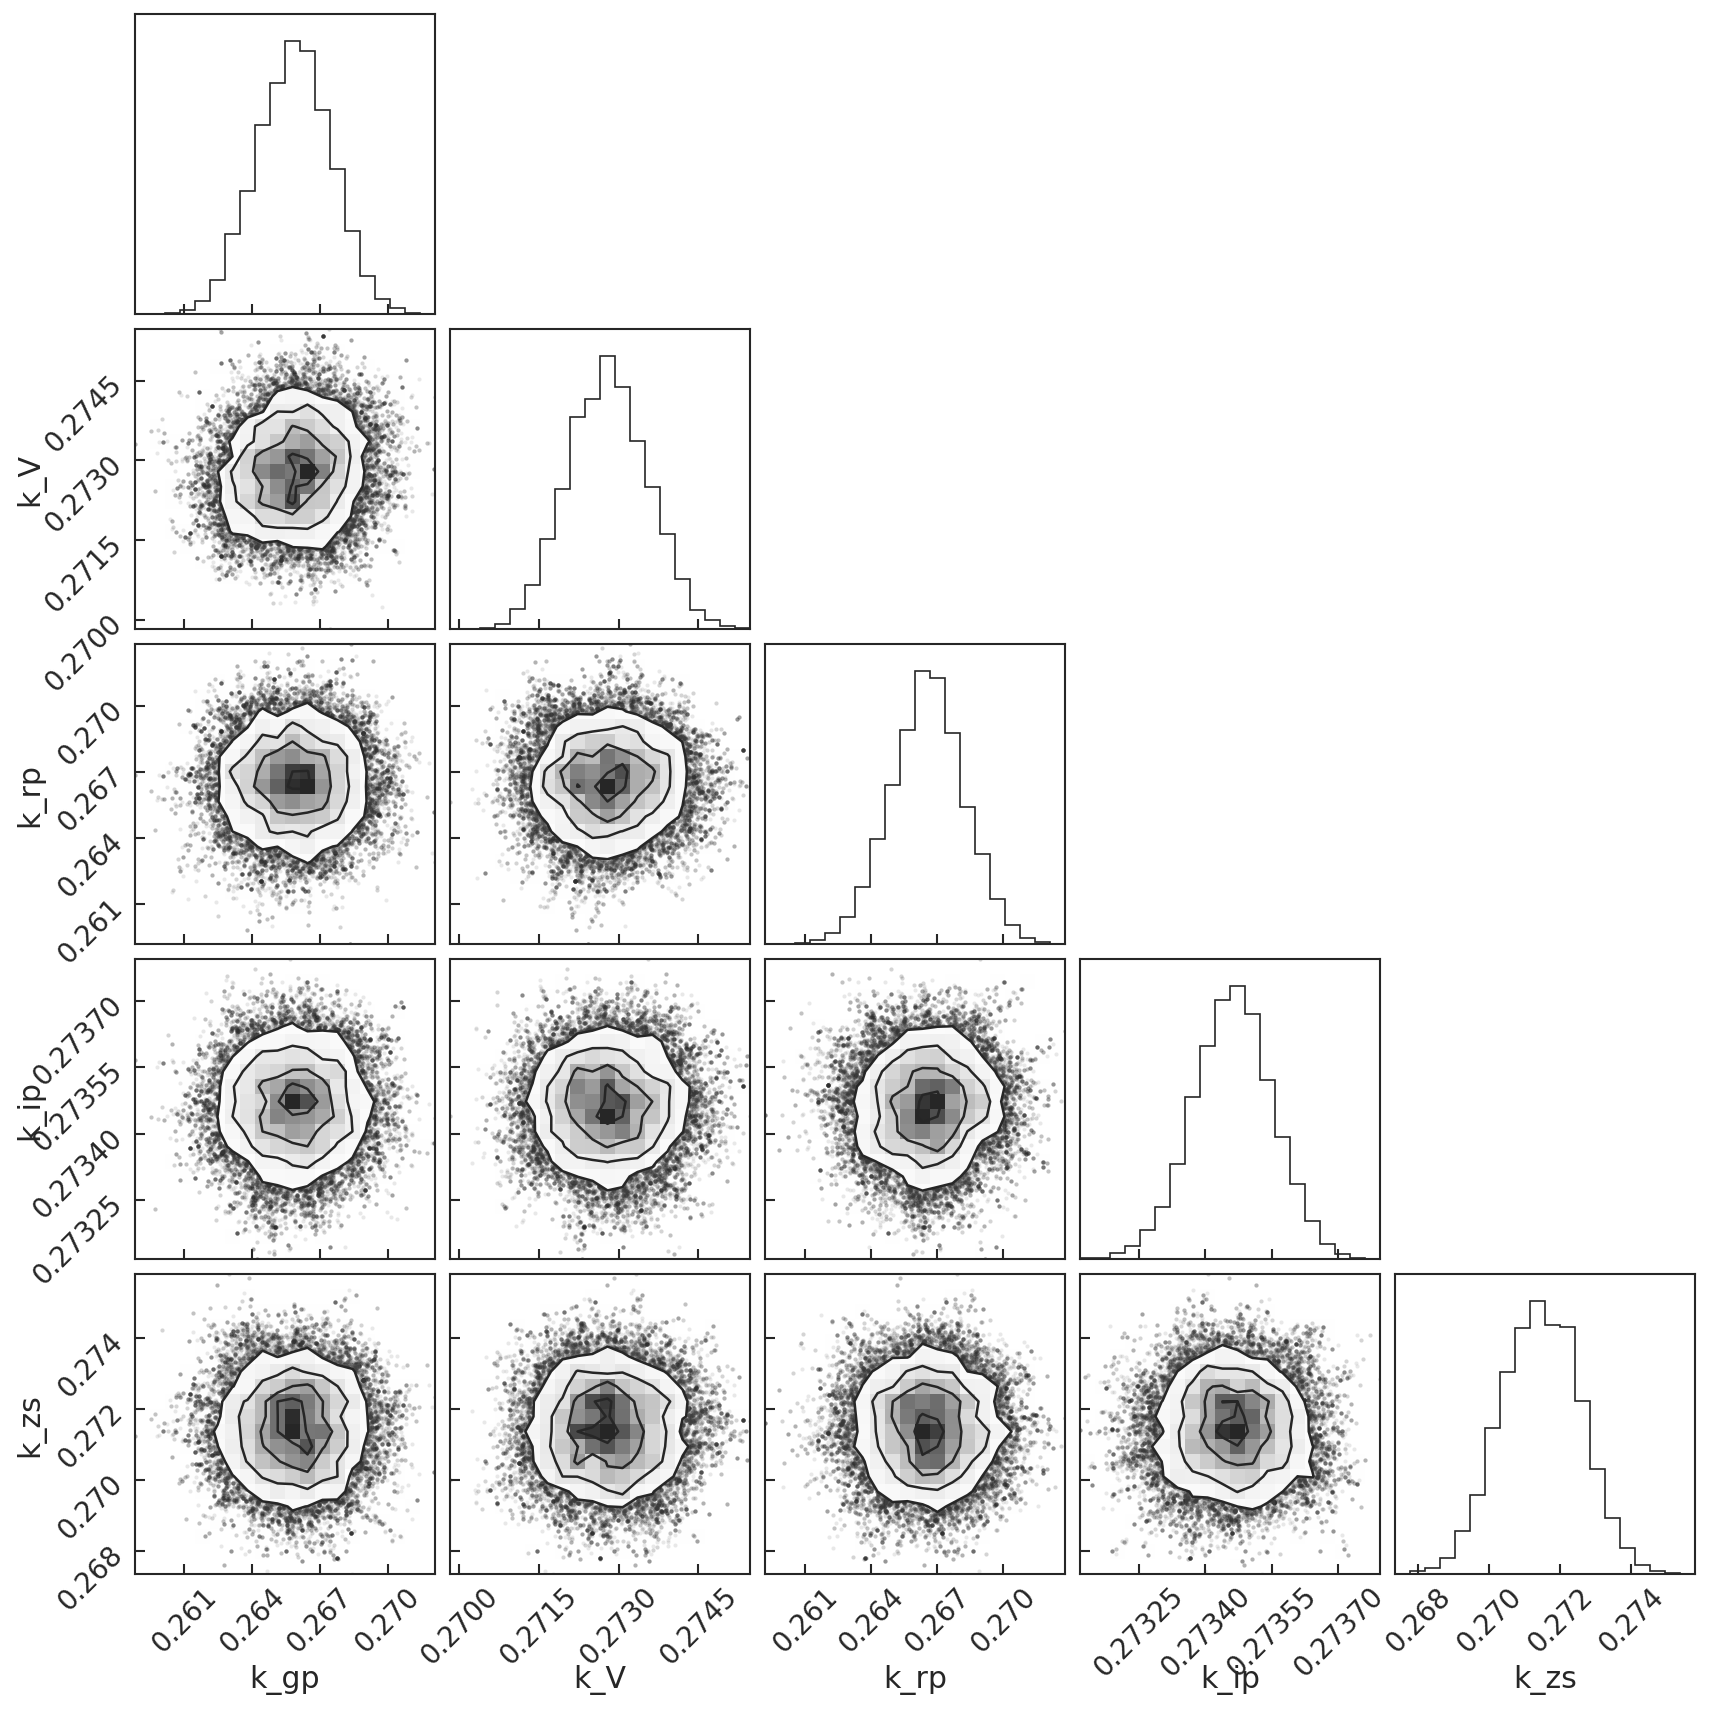

In [31]:
from corner import corner

idx = df.columns.str.contains('k_')
cols = df.columns[idx]
fig = corner(df[cols])

Text(0.5, 0, 'band')

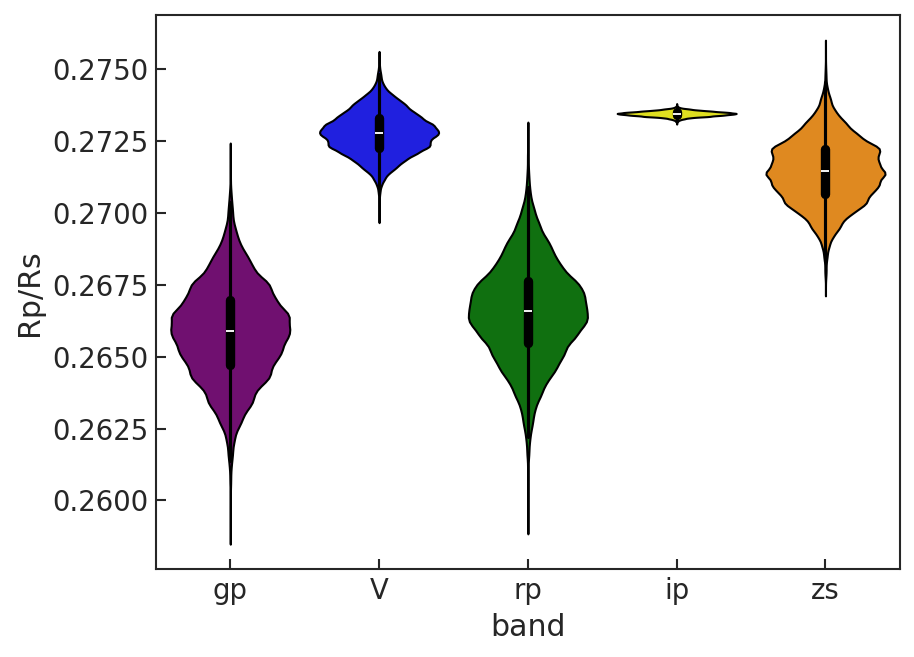

In [32]:
import seaborn as sb
ax = sb.violinplot(data=df[cols].rename({k:k[2:] for k in cols}, axis=1), 
                   palette=colors
                  )
ax.set_ylabel('Rp/Rs')
ax.set_xlabel('band')

In [43]:
from aesthetic.plot import savefig

savefig(fig, '../figures/RpRs.pdf', writepdf=False)

2024-02-24T15:35:54.981616: made ../figures/RpRs.pdf


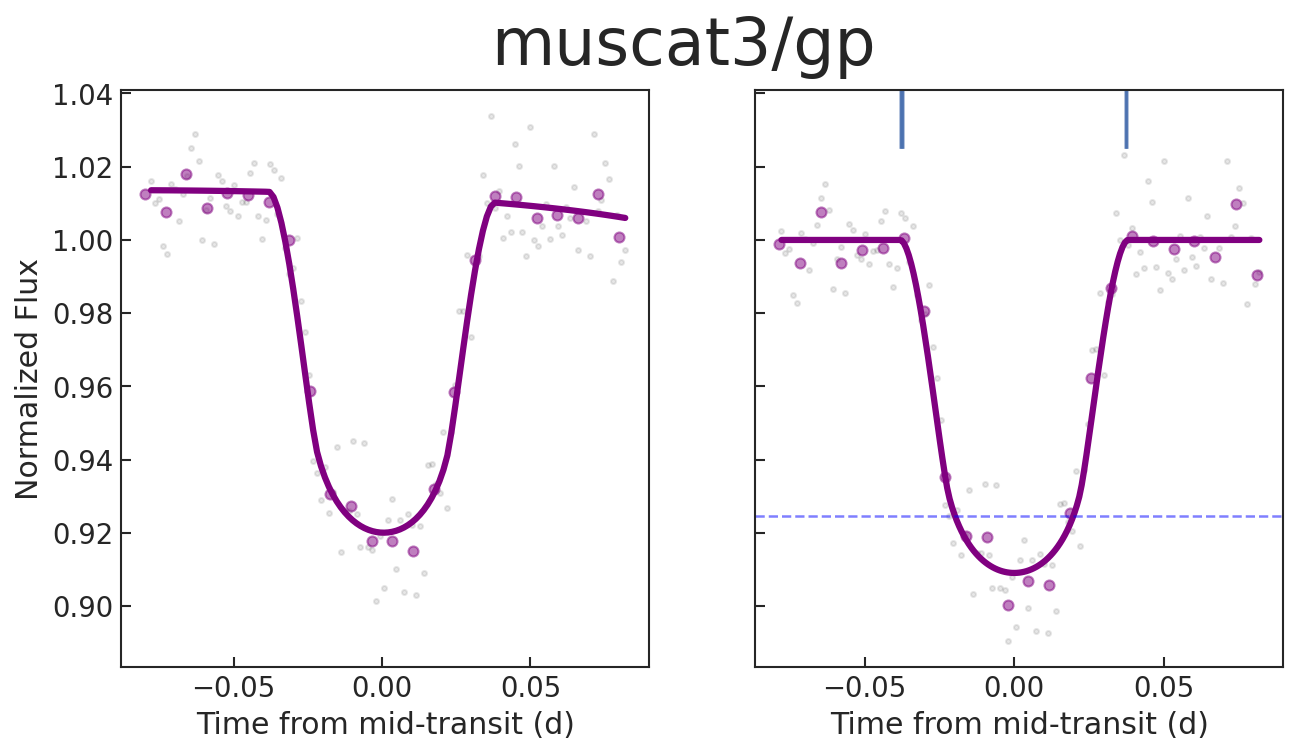

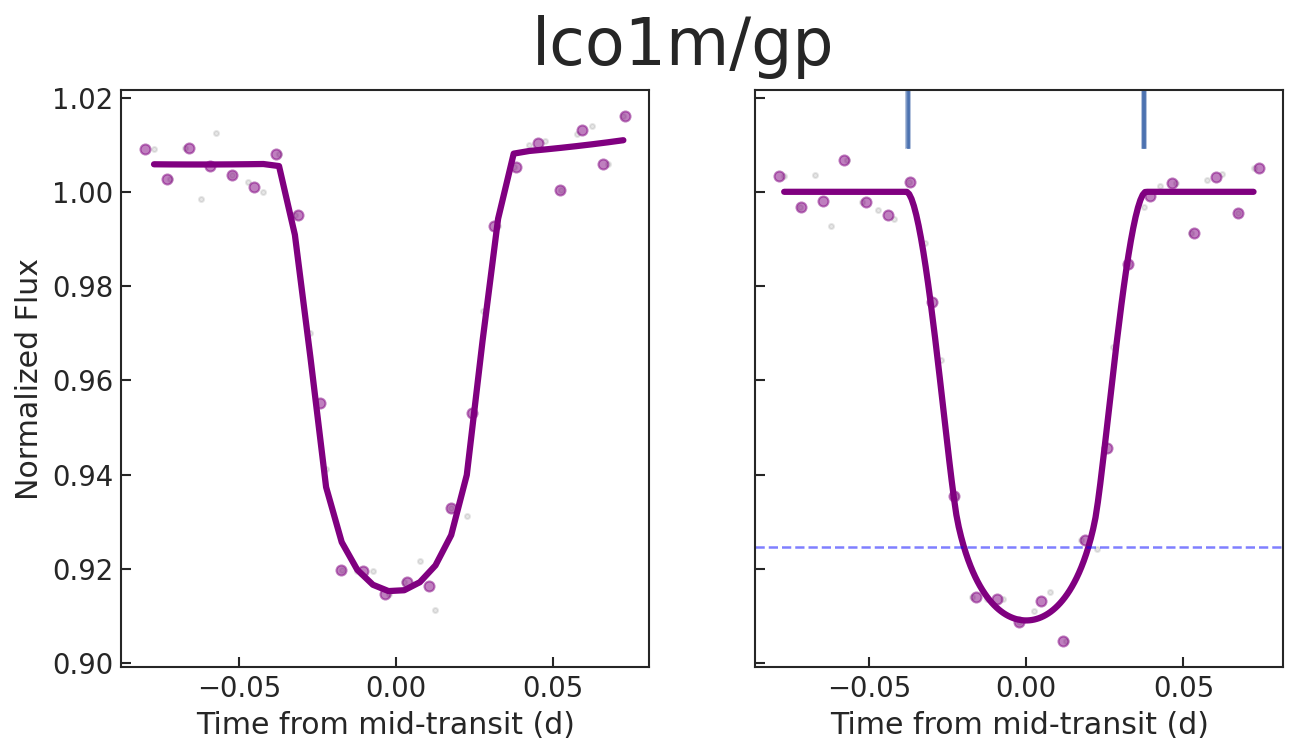

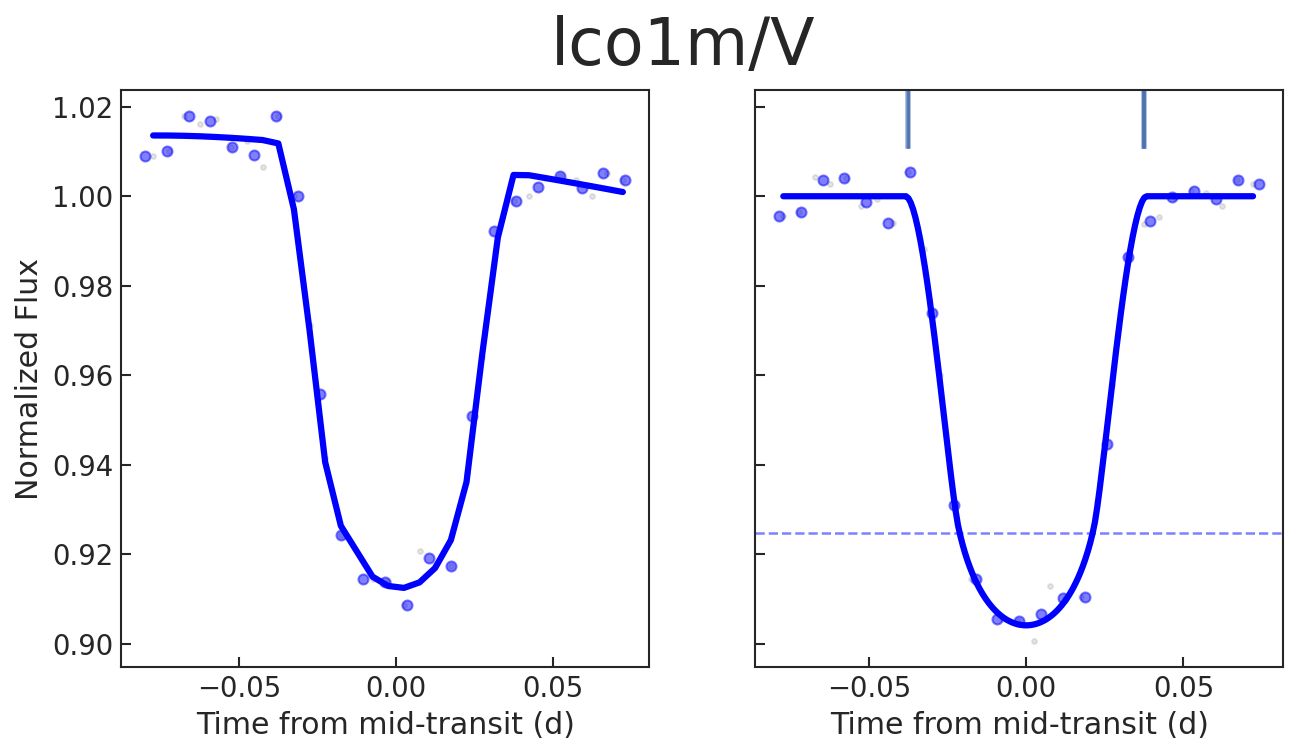

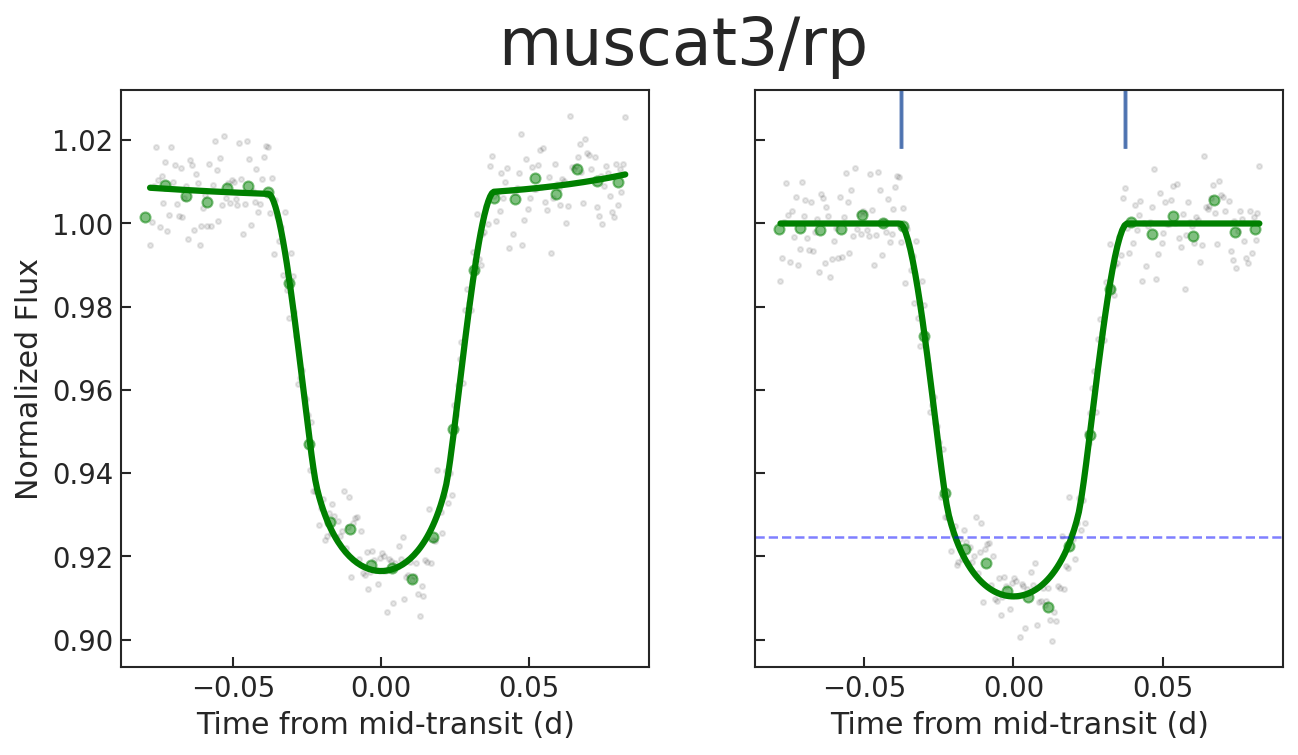

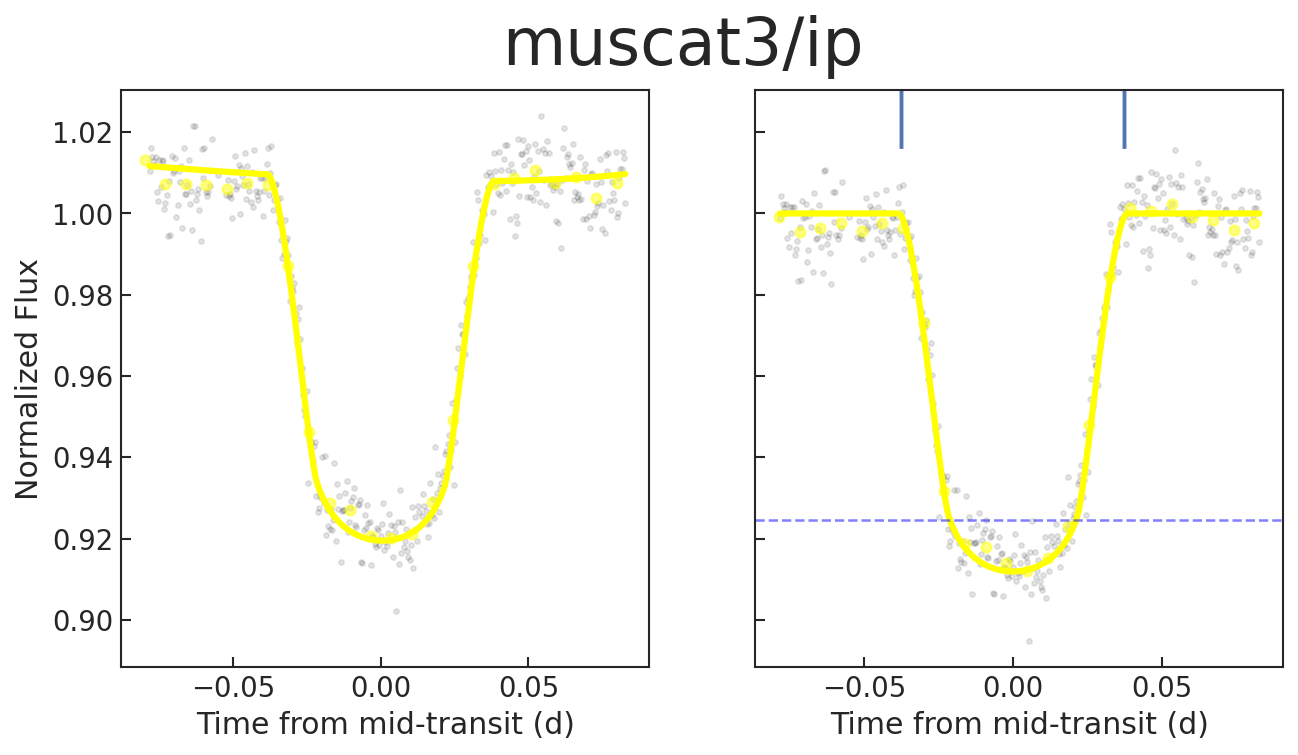

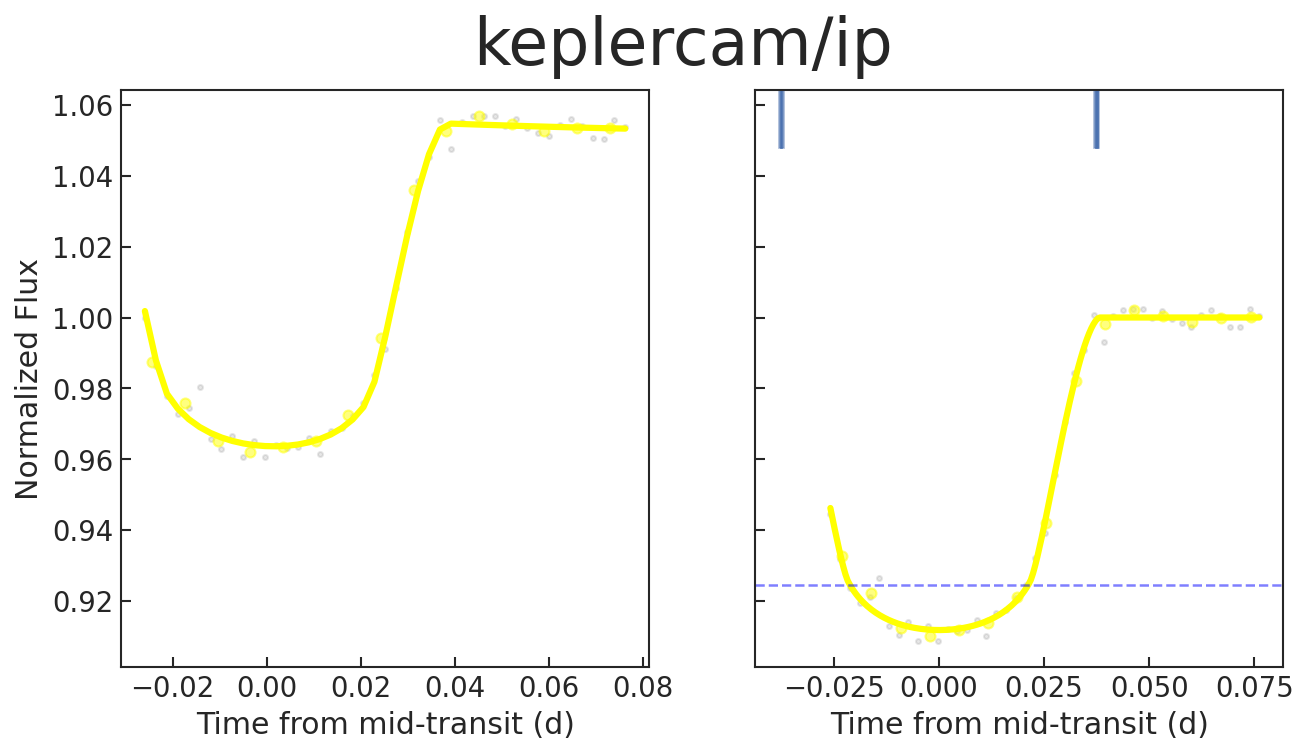

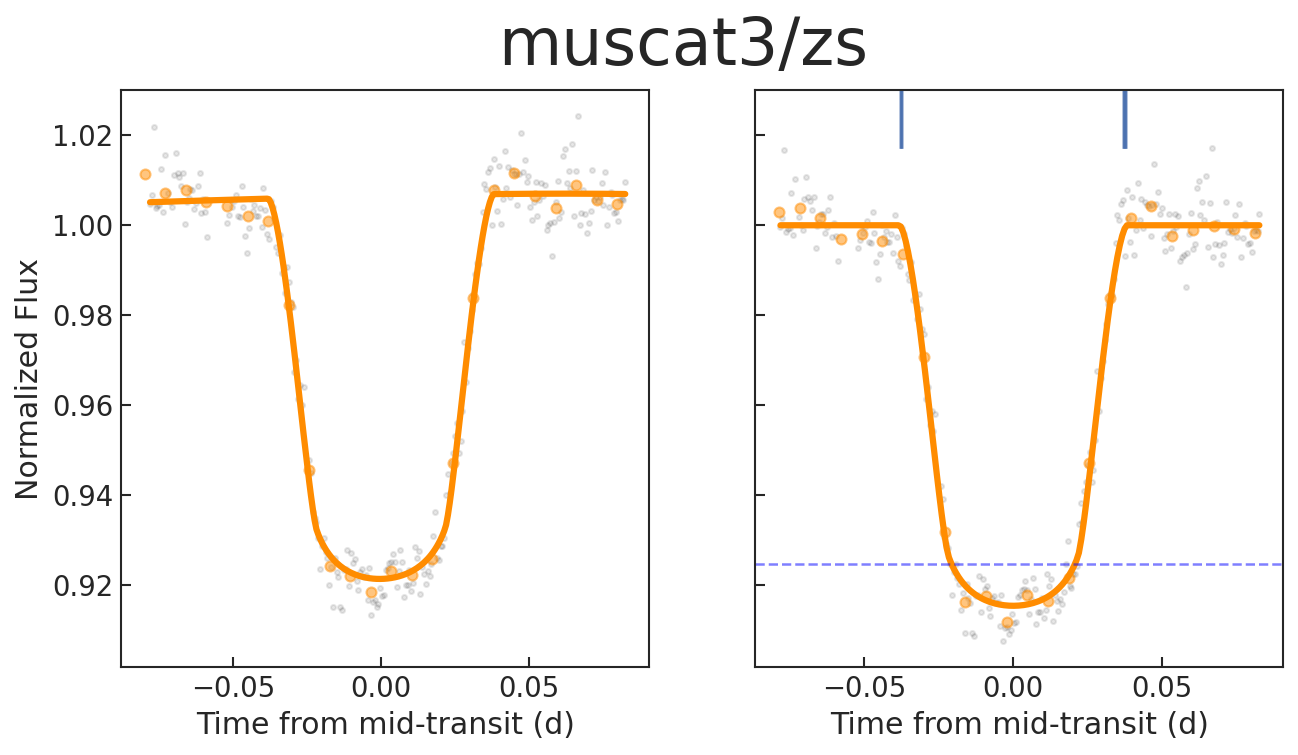

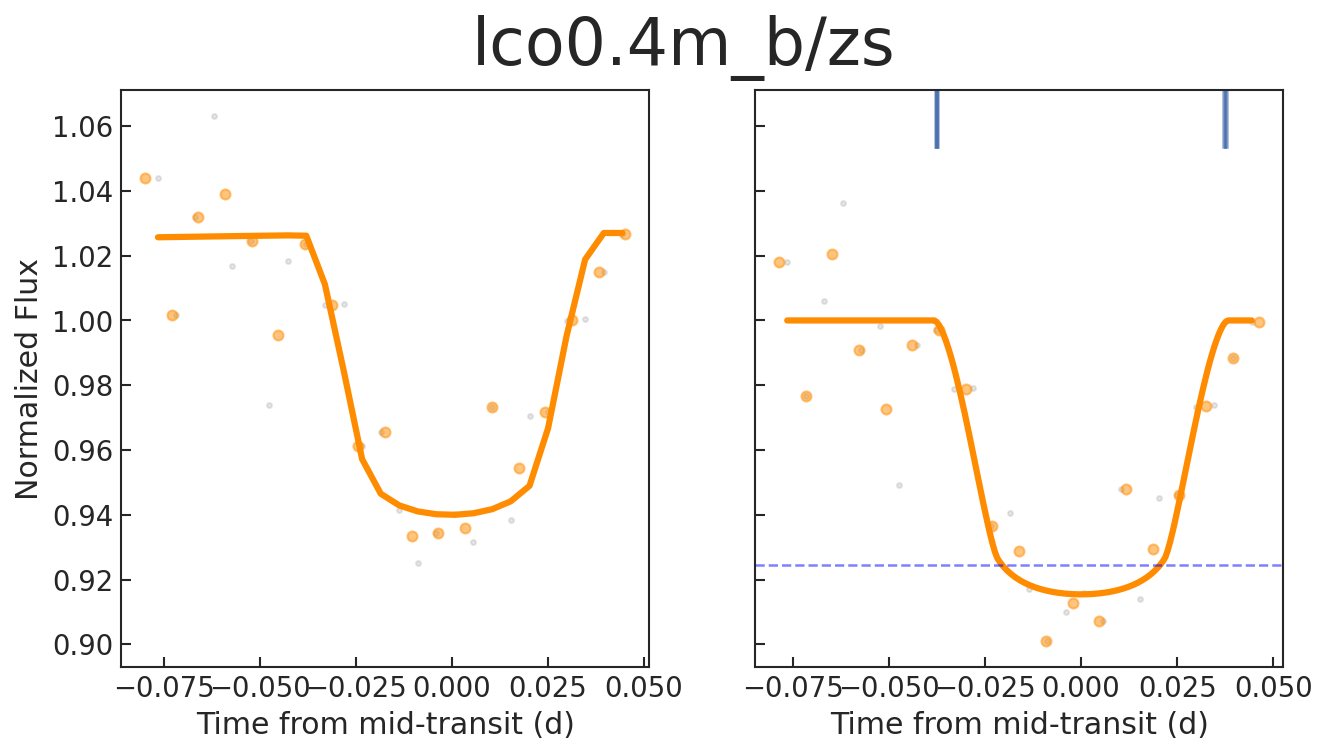

In [33]:
pv = tf.best_fit_params
fig = tf.plot_lightcurves(pv, figsize=(10,5))

In [62]:
from toi5671 import binning_equal_interval, AutoMinorLocator

def plot_final_fit(
    self,
    discard: int = 1,
    thin: int = 1,
    nsamples: int = 100,
    ylims_top: tuple = (0.9, 1.02),
    ylims_bottom: tuple = (0.9, 1.02),
    msize: int = 5,
    font_size: int = 25,
    title: str = None,
    figsize: tuple = (16, 12),
    binsize: float = 600 / 86400
):
    ymin1, ymax1 = ylims_top
    ymin2, ymax2 = ylims_bottom

    fig, ax = pl.subplots(
        2, self.ndatasets, figsize=figsize, sharey="row", sharex="col"
    )
    pl.subplots_adjust(hspace=0.1, wspace=0)
    
    # unpack free parameters
    if not hasattr(self, "best_fit_params"):
        raise ValueError("Run `sample_mcmc()` first.")

    pv = self.best_fit_params
    if self.use_r1r2:
        t0_best, per_best, a_Rs_best, r1, r2, d_best = self.unpack_parameters(pv)
        imp_best, k_best = r1r2_to_imp_k(
            r1, r2, k_lo=PRIOR_K_MIN, k_up=PRIOR_K_MAX
        )
    else:
        t0_best, per_best, a_Rs_best, imp_best, k_best, d_best = self.unpack_parameters(pv)

    # derived
    inc_best = np.arccos(imp_best / a_Rs_best)

    trends_best = self.get_trend_models(self.best_fit_params)
    transits_best = self.get_upsampled_transit_models(self.best_fit_params)

    # fc = self.sampler.get_chain(flat=True, discard=discard, thin=thin)
    fc = self.sampler.flatchain.copy()
    if discard > 1:
        fc = fc.reshape(self.nsteps, self.nwalkers, -1)
        fc = fc[discard::thin].reshape(-1, self.ndim)
    i = 0
    for n,(b,dfs) in enumerate(self.data.items()):
        for inst, df in dfs.items():
            t = self.times[b][inst]
            f = self.fluxes[b][inst]
            e = self.flux_errs[b][inst]
            z = self.covariates[b][inst]
            tc = get_epoch_tc(t, per_best, t0_best)
            dt = t-int(tc)
            # raw and binned data
            tbin, ybin, yebin = binning_equal_interval(dt, f, e, binsize, tc)
            ax[0, i].plot(dt, f, ".k", alpha=0.1)
            ax[0, i].errorbar(tbin, ybin, yerr=yebin, fmt="ok", markersize=msize)

            # plot each random mcmc samples
            rand = np.random.randint(len(fc), size=nsamples)
            for j in range(len(rand)):
                idx = rand[j]
                # unpack free parameters
                if self.use_r1r2:
                    tc, per, a_Rs, r1 = fc[idx, : self.k_idx]
                    if self.model == "chromatic":
                        r2 = fc[idx, self.k_idx : self.d_idx]
                    elif self.model == "achromatic":
                        r2 = np.zeros(self.nband) + fc[idx, self.k_idx]
                    imp, k = r1r2_to_imp_k(
                        r1, r2, k_lo=PRIOR_K_MIN, k_up=PRIOR_K_MAX
                    )
                else:
                    t0, per, a_Rs, imp = fc[idx, : self.k_idx]
                    if self.model == "chromatic":
                        k = fc[idx, self.k_idx : self.d_idx]
                    elif self.model == "achromatic":
                        k = np.zeros(self.nband) + fc[idx, self.k_idx]
                d = fc[idx, self.d_idx : self.d_idx + self.nband]
                # derived parameters
                inc = np.arccos(imp / a_Rs)
                # transit
                flux_tr = self.transit_models[b][inst].evaluate_ps(
                    k[n], self.ldc[b], tc, per, a_Rs, inc, e=0, w=0
                )
                flux_tr_time = d[i] * (t - tc) * flux_tr
                c = np.polyfit(z, (f - flux_tr_time) / flux_tr, self.lm_order)
                # transit with trend
                ax[0, i].plot(
                    dt,
                    flux_tr * (np.polyval(c, z) + d[i] * (t - tc)),
                    alpha=0.05,
                    color=colors[b],
                )

            # best-fit transit model
            flux_tr = self.transit_models[b][inst].evaluate_ps(
                k_best[i],
                self.ldc[b],
                t0_best,
                per_best,
                a_Rs_best,
                inc_best,
                e=0,
                w=0,
            )

            tbin, ybin, yebin = binning_equal_interval(
                dt, f / trends_best[b][inst], e, binsize, t0
            )
            # detrended flux
            ax[1, i].plot(dt, f / trends_best[b][inst], ".k", alpha=0.1)
            ax[1, i].errorbar(tbin, ybin, yerr=yebin, fmt="ok", markersize=msize)
            # super sampled best-fit transit model
            xmodel, ymodel = transits_best[b][inst]
            ax[1, i].plot(xmodel-int(tc), ymodel, color=colors[b], linewidth=3)
            ax[0, i].yaxis.set_minor_locator(AutoMinorLocator(5))
            ax[1, i].yaxis.set_minor_locator(AutoMinorLocator(5))
            ax[0, i].xaxis.set_minor_locator(AutoMinorLocator(5))
            ax[1, i].xaxis.set_minor_locator(AutoMinorLocator(5))
            ax[0, i].set_ylim(ymin1, ymax1)
            ax[1, i].set_ylim(ymin2, ymax2)

            tx = np.min(dt) + (np.max(dt) - np.min(dt)) * 0.75
            ty = ymin1 + (ymax1 - ymin1) * 0.9
            ax[0, i].text(
                tx, ty, f"{inst}/{b}", color=colors[b], fontsize=font_size * 0.6
            )
            tx = np.min(dt) + (np.max(dt) - np.min(dt)) * 0.02
            ty = ymin2 + (ymax2 - ymin2) * 0.8
            ax[1, i].text(tx, ty, "Detrended", fontsize=font_size * 0.6)

            rms = np.std(
                f - flux_tr * (np.polyval(c, z) + d_best[i] * (t - tc))
            )
            rms_text = f"rms = {rms:.4f}"
            ty = ymin2 + (ymax2 - ymin2) * 0.1
            ax[1, i].text(tx, ty, rms_text, fontsize=font_size * 0.6)
            depth = self.planet_params["rprs"][0] ** 2
            ax[1, i].axhline(
                1 - depth,
                color="blue",
                linestyle="dashed",
                label="TESS",
                alpha=0.5,
            )
            _ = self.plot_ing_egr(ax=ax[1, i], ymin=0.9, ymax=1.0, color="C0")
            if i == 0:
                ax[0, i].set_ylabel("Flux ratio", fontsize=font_size)
                ax[1, i].set_ylabel("Flux ratio", fontsize=font_size)
                ax[0, i].tick_params(labelsize=16)
                ax[1, i].tick_params(labelsize=16)
                target_name = (
                    f"{self.name}{self.alias}"
                    if title is None
                    else title
                )
                ax[0, i].text(
                    0.0,
                    1.14,
                    target_name,
                    horizontalalignment="left",
                    verticalalignment="center",
                    transform=ax[0, i].transAxes,
                    fontsize=font_size,
                )
                text = f"{self.model.title()} transit fit,  "
                text += f"$\Delta$BIC (non-transit - transit) = {self.bic_delta:.1f}"
                ax[0, i].text(
                    0.0,
                    1.05,
                    text,
                    horizontalalignment="left",
                    verticalalignment="center",
                    transform=ax[0, i].transAxes,
                    fontsize=font_size * 0.6,
                )
            # if (i > 0) and (i == self.nband - 1):
            #     ax[0, i].set_title("", loc="right", fontsize=font_size * 0.8)
            if i > 0:
                ax[0, i].tick_params(
                    labelleft=False,
                    labelright=False,
                    labeltop=False,
                    labelsize=16,
                )
                ax[1, i].tick_params(
                    labelleft=False,
                    labelright=False,
                    labeltop=False,
                    labelsize=16,
                )
            ax[1, i].set_xlabel(
                f"BJD - {int(tc):.0f}",
                labelpad=30,
                fontsize=font_size,
            )
        i+=1
    ax[1, i].legend(loc="lower right", fontsize=12)
    return fig

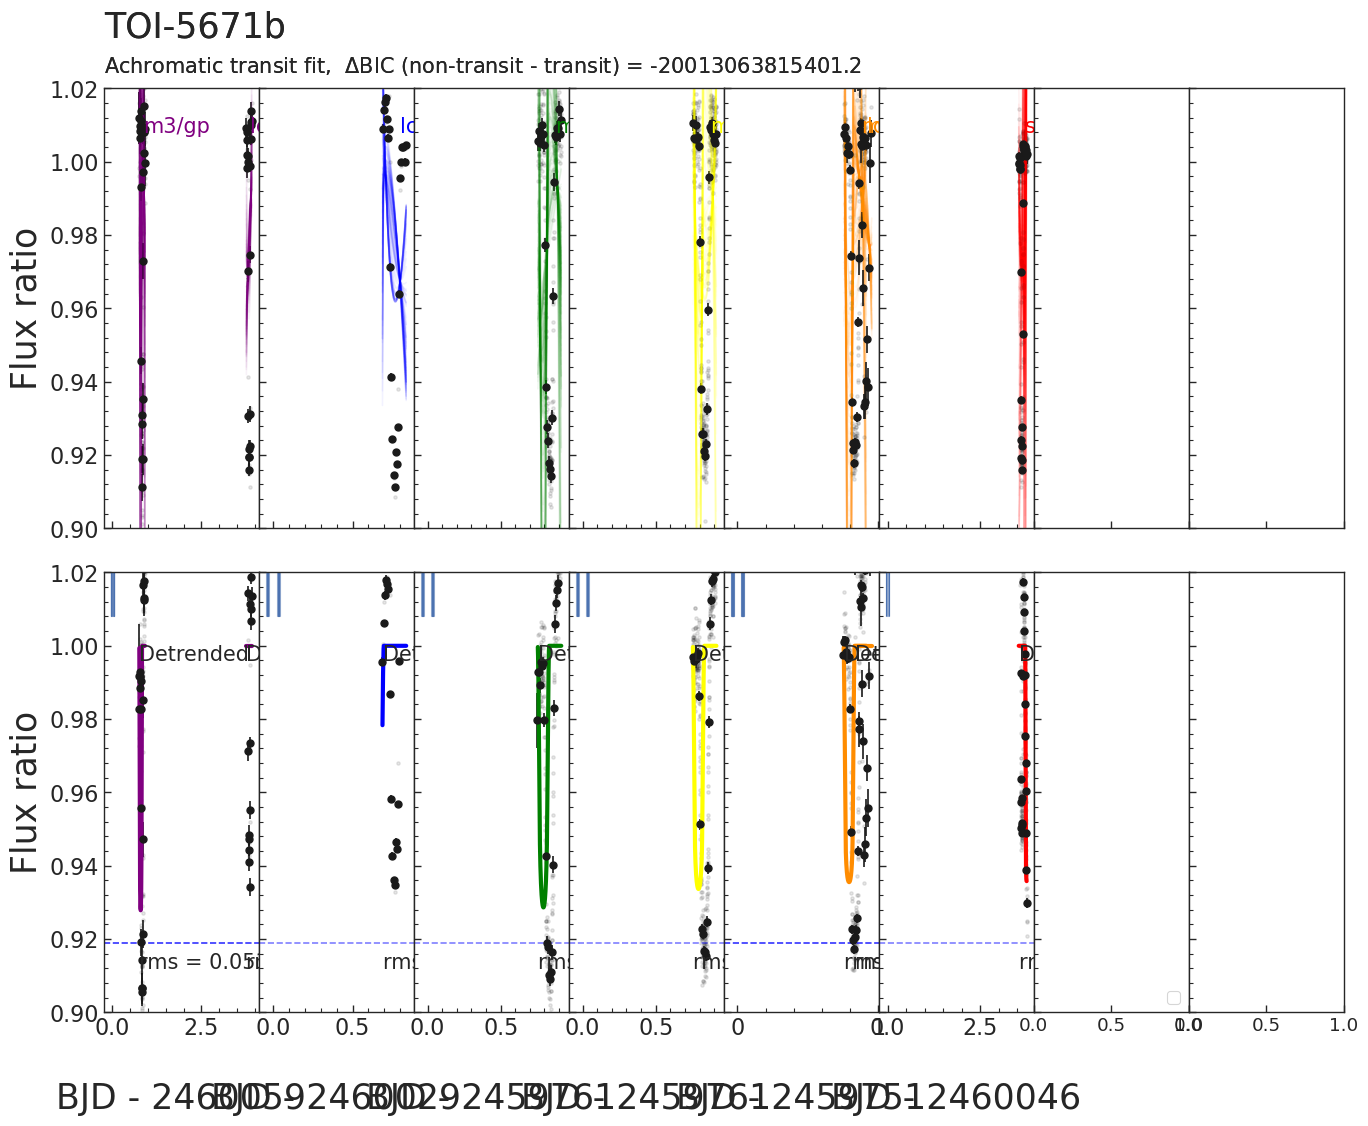

In [63]:
fig = plot_final_fit(tf)